In [1]:
import sys
sys.path.append('../src/')
import decode_mcd
import decode_mcd.multi_objective_problem as MOP
from decode_mcd import data_package


from decode_mcd import design_targets
from decode_mcd import counterfactuals_generator

import numpy as np

### Creating a random dataset

First, let's create a toy dataset for testing. Our design variables will just be two randomized variables ranging from 0 to 1. We'll generate 10 toy datapoints. We call this the `features_dataset`

In [2]:
np.random.seed(0) #set random seed to make this notebook repeatable
features_dataset = np.random.random((10,2))
print(features_dataset)

[[0.5488135  0.71518937]
 [0.60276338 0.54488318]
 [0.4236548  0.64589411]
 [0.43758721 0.891773  ]
 [0.96366276 0.38344152]
 [0.79172504 0.52889492]
 [0.56804456 0.92559664]
 [0.07103606 0.0871293 ]
 [0.0202184  0.83261985]
 [0.77815675 0.87001215]]


Now, let's create design evaluation function, `evaluate()`. We'll say that our quantity of interest is just the sum of the two design variables.

In [3]:
def evaluate(x): 
    #MCD uses pandas dataframes internally. More in this in the next notebook. 
    x = np.array(x)  #For now, we convert to numpy for simplicity, in the event x is a different type.
    y = x[:,0] + x[:,1]
    y = y.reshape(-1,1) #reshaping here is important. We need to return a 2D array. 
    return y

Finally, we'll evaluate the designs in the dataset. We call these the `predictions_dataset`, as the evaluator is often an ML model

In [4]:
predictions_dataset = evaluate(features_dataset)
print(predictions_dataset)

[[1.26400287]
 [1.14764656]
 [1.06954891]
 [1.32936021]
 [1.34710428]
 [1.32061996]
 [1.4936412 ]
 [0.15816536]
 [0.85283824]
 [1.6481689 ]]


Finally, lets create a design as our query, which we call `query_x`. Note that `query_x` is a 2D array. This is design that we would like MCD to modify.

In [5]:
query_x = np.array([[0.3, 0.2]])
query_y = evaluate(query_x)

Great! Let's plot what we've got. We will make a scatterplot of the dataset and the query and color-code the values based on objective value

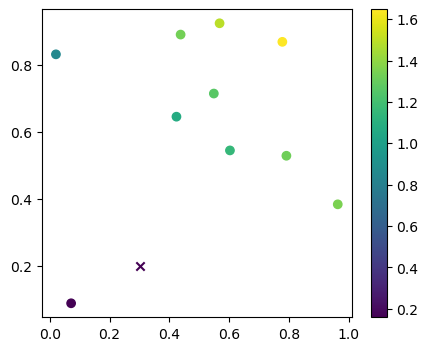

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,4))
plt.scatter(features_dataset[:,0], features_dataset[:,1], c=predictions_dataset, marker='o')
plt.colorbar() 
plt.scatter(query_x[:,0], query_x[:,1], c=query_y, marker='x') 

### Creating MCD DataPackage

Now, we create an instance of a MCD `DataPackage`. The `DataPackage` requires the design dataset (`features_dataset`), the evaluated objective values (`predictions_dataset`), and the query (`query_x`). But we also need two more components, the `design targets` and the `datatypes`. Here's how to set them up.

The design targets are a list of individual targets

In [7]:
target_1 = design_targets.ContinuousTarget(label = 0, lower_bound=1, upper_bound=1.5)
targets = design_targets.DesignTargets([target_1])

In [8]:
from pymoo.core.variable import Real
data = data_package.DataPackage(features_dataset=features_dataset,
                           predictions_dataset=predictions_dataset,
                           query_x=query_x,
                           design_targets=targets,
                           datatypes=[Real(bounds=(0, 1)),Real(bounds=(0, 1))])

Next, we set up the MCD `MultiObjectiveProblem` instance, which takes in the `DataPackage` we just created, as well as our evaluation function.

In [9]:
problem = MOP.MultiObjectiveProblem(data_package=data, prediction_function=evaluate)

In [10]:


generator = counterfactuals_generator.CounterfactualsGenerator(problem=problem,
                                     pop_size=100,
                                     initialize_from_dataset=False)

generator.generate(n_generations=10)
counterfactuals = generator.sample_with_dtai(num_samples=10, gower_weight=1,
                                             avg_gower_weight=1, cfc_weight=1,
                                             diversity_weight=50, include_dataset=False)

Initial population randomly initialized!
Training GA from 0 to 10 generations!
n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |       99 |      7 |  0.000000E+00 |  0.1867736333 |             - |             -
     2 |      199 |     10 |  0.000000E+00 |  0.0178091687 |  0.0367189576 |             f
     3 |      299 |     16 |  0.000000E+00 |  0.000000E+00 |  1.0000000000 |         ideal
     4 |      399 |     19 |  0.000000E+00 |  0.000000E+00 |  0.0333130480 |             f
     5 |      499 |     28 |  0.000000E+00 |  0.000000E+00 |  0.0109273641 |         ideal
     6 |      599 |     36 |  0.000000E+00 |  0.000000E+00 |  0.0046229941 |             f
     7 |      699 |     53 |  0.000000E+00 |  0.000000E+00 |  0.0087990602 |         ideal
     8 |      799 |     79 |  0.000000E+00 |  0.000000E+00 |  0.2109279865 |         nadir
     9 |      899 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0038767672 |         ideal
    10 |   

In [11]:
counterfactuals = np.array(counterfactuals) #convert to numpy array for plotting
print(counterfactuals)

[[0.98686597 0.2       ]
 [0.13801527 0.95446372]
 [0.50319053 0.52167718]
 [0.63427406 0.86397874]
 [0.83659925 0.63014668]
 [0.30016938 0.71978528]
 [0.68005557 0.32599488]
 [0.97857093 0.46949718]
 [0.39217308 0.97065703]
 [0.58131481 0.68097313]]


Now, lets repeat our plot from earlier, but add the generated counterfactuals. We also add the objective ranges as dotted lines. We see that the generated counterfactuals (+) fall within the designated boundaries. 

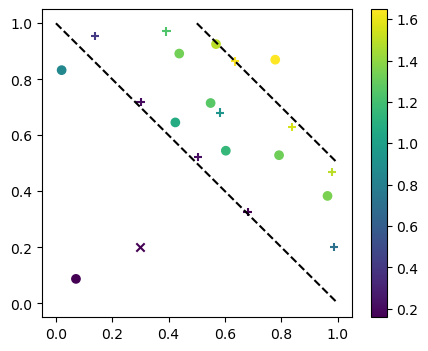

In [12]:
cf_y = evaluate(counterfactuals)

plt.figure(figsize=(5,4))
plt.scatter(features_dataset[:,0], features_dataset[:,1], c=predictions_dataset, marker='o')
plt.colorbar() 
plt.scatter(counterfactuals[:,0], counterfactuals[:,1], c=cf_y, marker='+')
plt.scatter(query_x[:,0], query_x[:,1], c=query_y, marker='x') 

plt.plot([0,1], [1,0], 'k--')
plt.plot([0.5,1], [1,0.5], 'k--')